In [1]:
from prevo.record import RecordBase, RecordingBase, SensorBase
from prevo.csv import RecordingToCsv
from prevo.misc import DummyPressureSensor, DummyTemperatureSensor
import pandas as pd
%matplotlib tk

# Define sensors

In [2]:
class Sensor(SensorBase):
    """Provide methods common to all sensors"""
    
    def  _get_data(self):
        """Automatically add time and time uncertainty in data dict.
        
        If one does not want to add time info to measurements, or if one
        wants to use time info from the sensors themselves, the method
        _read() must be subclassed instead of _get_data().
        """
        measurement = self.device.read()
        return tuple(measurement.values())

In [3]:
class PressureSensor(Sensor):
    
    name = 'P'
    
    # This will be the names of columns in the CSV file
    # (as can be seen below, time columns are also added automatically)
    data_names = 'P1', 'P2', 'P3'
    
    # data_types is useful only when using live graphs
    data_types = 'P (Pa)', 'P (Pa)', 'P (mbar)'
    
    def __init__(self):
        self.device = DummyPressureSensor()


class TemperatureSensor(Sensor):
    
    name = 'T'
    data_names = 'T1', 'T2'
    data_types = 'T (°C)', 'T (°C)'
    
    def __init__(self):
        self.device = DummyTemperatureSensor()

In [4]:
with PressureSensor() as sensor:
    data = sensor.read()
data

{'values': (3170.1163596469946, 2338.3641050654473, 17.10450680140587),
 'time (unix)': 1690556987.7869794,
 'dt (s)': 0.00011152098886668682}

# Define recordings / record objects

In [5]:
class Recording(RecordingToCsv, RecordingBase):
    """Recording class that defines how to read and handle data from sensors."""

    def __init__(self, Sensor, programs=()):
        """The 'programs' argument will be used only further below and
        can be ignored in simple situations."""

        column_names = ('time (unix)', 'dt (s)') + Sensor.data_names
        filename = 'Pressure.tsv' if Sensor.name == 'P' else 'Temperature.tsv'

        RecordingBase.__init__(self, Sensor=Sensor, path='data', programs=programs)
        RecordingToCsv.__init__(self, path='data', filename=filename, column_names=column_names)
       
 
class Record(RecordBase):
    """For simple cases no subclassing is necessary"""
    pass

# Start recording

**IMPORTANT NOTE**: Below, by default recordings are OFF (`on=False`) option. After starting the recording, turn them on by typing `on True` in the CLI

In [6]:
recordings = Recording(PressureSensor), Recording(TemperatureSensor)
record = Record(recordings, dt=3, dt_P=0.5, on=False)
record.start()

Recording started in folder /Users/olivier.vincent/Python-OV/prevo/examples


Type command (help: ?):  q


CLI stopped
Recording Stopped


In [10]:
pressure_data = pd.read_csv('data/Pressure.tsv', sep='\t')
pressure_data.head()

,time (unix),dt (s),P1,P2,P3
0,1.690554e+09,0.000053,3170.086843,2338.395726,17.264083
1,1.690554e+09,0.000022,3170.464515,2339.049874,17.473451
2,1.690554e+09,0.000031,3170.758837,2339.919008,17.527811
3,1.690554e+09,0.000035,3170.433966,2339.869703,17.532837
4,1.690554e+09,0.000053,3170.340078,2338.567331,17.117914


In [11]:
pressure_data.plot(x='time (unix)', y='P1', style='o')

<Axes: xlabel='time (unix)'>

# Program recording

It is possible to program recording properties, for example to change automatically the time interval between data points after some time, or to start / stop recording certain sensors at given times.

/Users/olivier.vincent/Python-OV/prevo/prevo/control/program.py:208: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


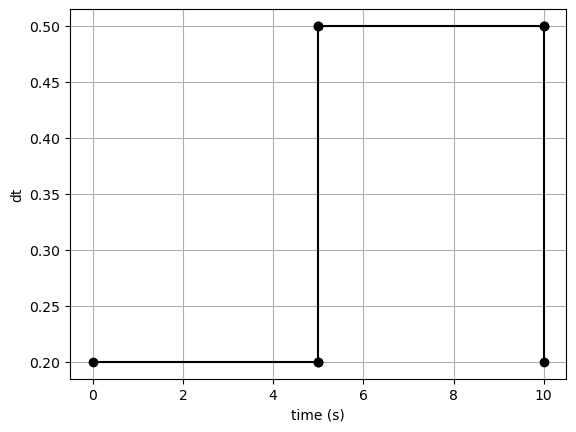

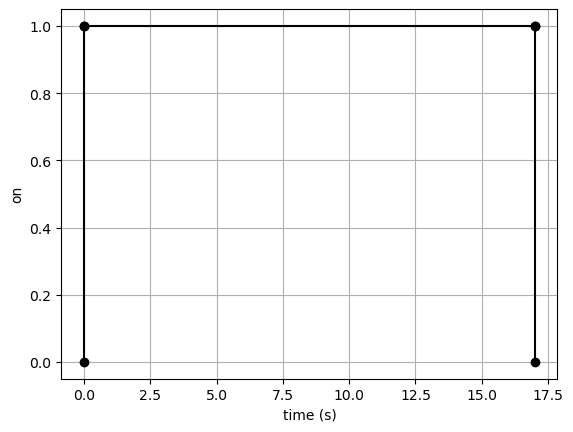

In [9]:
from prevo.control import Program, Stairs

prog_dt = Stairs(duration='::5', dt=[0.2, 0.5])
prog_on = Program(durations=('::', '::17', '::'), on=[False, True, True])

prog_dt.plot(time_unit='s')
prog_on.plot(time_unit='s')

In [12]:
# With these options, the time interval of the pressure recording will oscillate
# between 0.2 and 0.5 seconds every 5 seconds, and both recordings will stop
# after 17 seconds.
# The 'path' argument of the recording

recordings = (
    Recording(PressureSensor, programs=(prog_on, prog_dt)),
    Recording(TemperatureSensor, programs=(prog_on,)),
)
Record(recordings).start()


Recording started in folder /Users/olivier.vincent/Python-OV/prevo/examples
[2023-07-28 16:27:35] ------ PROGRAM (on)--- NEW CYCLE 1 / 1

[2023-07-28 16:27:35] ------ PROGRAM (on)--- NEW CYCLE 1 / 1

[2023-07-28 16:27:35] ------ PROGRAM (dt)--- NEW CYCLE 1 / 1

[2023-07-28 16:27:47] ------ PROGRAM (dt)--- FINISHED

[2023-07-28 16:27:54] ------ PROGRAM (on)--- FINISHED

[2023-07-28 16:27:54] ------ PROGRAM (on)--- FINISHED

CLI stopped
Recording Stopped


<Axes: xlabel='time (unix)'>

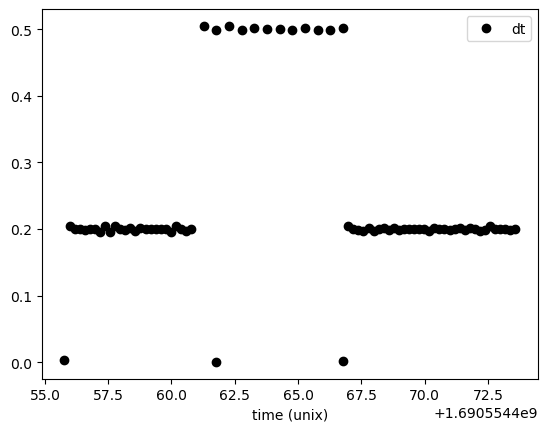

In [17]:
pressure_data = pd.read_csv('data/Pressure.tsv', sep='\t')
pressure_data['dt'] = pressure_data['time (unix)'].diff()
pressure_data.plot(x='time (unix)', y='dt', style='ok')

# View recorded data in real time

**ATTENTION**, this section requires the use of an interactive backend for matplotlib (e.g. tk or qt)

The record class must be subclassed to indicate what to do when a graphing event is requested in the CLI during recording
(this is done by typing `g` or `graph`)

In [9]:
from prevo.plot import NumericalGraph

Sensors = PressureSensor, TemperatureSensor
data_types = {Sensor.name: Sensor.data_types for Sensor in Sensors}


class RecordWithGraph(Record):

    def data_plot(self):
        """What to do when graph event is triggered."""
        
        print(self.recordings)
        
        graph = NumericalGraph(names=self.recordings, data_types=data_types)
        
        # Note that the data for plotting is automatically added to the queue
        # self.q_plot when the graph is triggered.
        # Passing the e_stop and e_graph arguments allows to connect the
        # graph object to events from the CLI.
        graph.run(q_plot=self.q_plot,
                  e_stop=self.e_stop,
                  e_graph=self.e_graph)

In [11]:
recordings = Recording(PressureSensor), Recording(TemperatureSensor)
record = RecordWithGraph(recordings).start()

Recording started in folder /Users/olivier.vincent/Python-OV/prevo/examples


Type command (help: ?):  g


Graph event requested
{'P': Recording (P), 'T': Recording (T)}


Type command (help: ?):  q


CLI stopped
Recording Stopped
